# Sweeping Parameters

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [3]:
# import functions from modsim

from modsim import *

The following cells download the code from Chapter 3 and import the `step` function we defined.

In [4]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/chap03.py')

In [5]:
from chap03 import step

In the previous chapter we defined metrics that quantify the performance of a bike sharing system.
In this chapter we'll see how those metrics depend on the parameters of the system, like the arrival rate of customers at the stations.

And I will present a program development strategy, called incremental
development, that might help you write programs faster and spend less
time debugging.

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

## Functions That Return Values

We have used several functions that return values.
For example, when you run `sqrt`, it returns a number you can assign to a variable.

In [6]:
from numpy import sqrt

root_2 = sqrt(2)
root_2

1.4142135623730951

And when you run `State`, it returns a new `State` object:

In [7]:
bikeshare = State(olin=10, wellesley=2)
bikeshare

olin         10
wellesley     2
Name: state, dtype: int64

Not all functions have return values. For example, when you run `step`,
it updates a `State` object, but it doesn't return a value.

To write functions that return values, we can use a `return` statement, like this:

In [8]:
def add_five(x):
    return x + 5

`add_five` takes a parameter, `x`, which could be any number. It
computes `x + 5` and returns the result. So if we run it like this, the
result is `8`:

In [9]:
add_five(3)

8

As a more useful example, here's a version of `run_simulation` that
creates a `State` object, runs a simulation, and then returns the
`State` object:

In [10]:
def run_simulation(p1, p2, num_steps):
    state = State(olin=10, wellesley=2,
                  olin_empty=0, wellesley_empty=0)
    
    for i in range(num_steps):
        step(state, p1, p2)
        
    return state

We can call `run_simulation` like this:

In [11]:
final_state = run_simulation(0.3, 0.2, 60)

The result is a `State` object that represents the final state of the system, including the metrics we'll use to evaluate the performance of the system:

In [12]:
print(final_state.olin_empty, 
      final_state.wellesley_empty)

0 0


The simulation we just ran starts with `olin=10` and `wellesley=2`, and uses the values `p1=0.3`, `p2=0.2`, and `num_steps=60`. 
These five values are *parameters of the model*, which are quantities that determine the behavior of the system.

It is easy to get the parameters of a model confused with the parameters of a function. 
It is especially easy because the parameters of a model often appear as parameters of a function.

For example, the previous version of `run_simulation` takes `p1`, `p2`, and `num_steps` as parameters.
So we can call `run_simulation` with different parameters and see how
the metrics, like the number of unhappy customers, depend on the
parameters. But before we do that, we need a new version of a `for` loop.

## Loops and Arrays

In `run_simulation`, we use this `for` loop:

```
    for i in range(num_steps):
        step(state, p1, p2)
```

In this example, `range` creates a sequence of numbers from `0` to `num_steps` (including `0` but not `num_steps`). 
Each time through the loop, the next number in the sequence gets assigned to the loop variable, `i`.

But `range` only works with integers; to get a sequence of non-integer
values, we can use `linspace`, which is provided by NumPy:

In [13]:
from numpy import linspace

p1_array = linspace(0, 1, 5)
p1_array

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

The arguments indicate where the sequence should start and stop, and how
many elements it should contain. In this example, the sequence contains
`5` equally-spaced numbers, starting at `0` and ending at `1`.

The result is a NumPy *array*, which is a new kind of object we have
not seen before. An array is a container for a sequence of numbers.

We can use an array in a `for` loop like this:

In [14]:
for p1 in p1_array:
    print(p1)

0.0
0.25
0.5
0.75
1.0


When this loop runs, it

1.  Gets the first value from the array and assigns it to `p1`.

2.  Runs the body of the loop, which prints `p1`.

3.  Gets the next value from the array and assigns it to `p1`.

4.  Runs the body of the loop, which prints `p1`.

5. ...

And so on, until it gets to the end of the array. This will come in handy in the next section.

## Sweeping Parameters

If we know the actual values of parameters like `p1` and `p2`, we can
use them to make specific predictions, like how many bikes will be at
Olin after one hour.

But prediction is not the only goal; models like this are also used to
explain why systems behave as they do and to evaluate alternative
designs. For example, if we observe the system and notice that we often run out of bikes at a particular time, we could use the model to figure out why that happens. And if we are considering adding more bikes, or another station, we could evaluate the effect of various "what if" scenarios.

As an example, suppose we have enough data to estimate that `p2` is
about `0.2`, but we don't have any information about `p1`. We could run simulations with a range of values for `p1` and see how the results vary. This process is called *sweeping* a parameter, in the sense that the value of the parameter "sweeps" through a range of possible values.

Now that we know about loops and arrays, we can use them like this:

In [15]:
p1_array = linspace(0, 0.6, 6)
p2 = 0.2
num_steps = 60

for p1 in p1_array:
    final_state = run_simulation(p1, p2, num_steps)
    print(p1, final_state.olin_empty)

0.0 0
0.12 0
0.24 0
0.36 4
0.48 12
0.6 22


Each time through the loop, we run a simulation with a different value
of `p1` and the same value of `p2`, `0.2`. Then we print `p1` and the
number of unhappy customers at Olin.

To save and plot the results, we can use a `SweepSeries` object, which
is similar to a `TimeSeries`; the difference is that the labels in a
`SweepSeries` are parameter values rather than time values.

We can create an empty `SweepSeries` like this:

In [16]:
sweep = SweepSeries()

And add values like this:

In [17]:
p1_array = linspace(0, 0.6, 31)

for p1 in p1_array:
    final_state = run_simulation(p1, p2, num_steps)
    sweep[p1] = final_state.olin_empty

The result is a `SweepSeries` that maps from each value of `p1` to the
resulting number of unhappy customers.

We can display the results like this:

In [18]:
show(sweep)

,Metric
Parameter,
0.00,0
0.02,0
0.04,0
0.06,0
0.08,0
0.10,0
0.12,0
0.14,0
0.16,0


We can plot the elements of the `SweepSeries` like this:

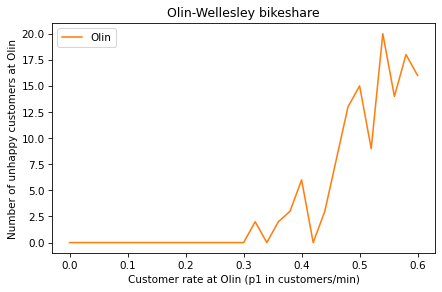

In [19]:
sweep.plot(label='Olin', color='C1')

decorate(title='Olin-Wellesley bikeshare',
         xlabel='Customer rate at Olin (p1 in customers/min)', 
         ylabel='Number of unhappy customers at Olin')

The keyword argument `color='C1'` specifies the color of the line.
The `TimeSeries` we have plotted so far use the default color, `C0`, which is blue (see <https://matplotlib.org/stable/tutorials/colors/colors.html> for the other colors defined by Matplotlib).
I use a different color for `SweepSeries` to remind us that it is not a `TimeSeries`.

When the arrival rate at Olin is low, there are plenty of bikes and no unhappy customers.
As the arrival rate increases, we are more likely to run out of bikes and the number of unhappy customers increases. The line is jagged because the simulation is based on random numbers. Sometimes we get lucky and there are relatively few unhappy customers; other times we are unlucky and there are more. 

## Incremental Development

When you start writing programs that are more than a few lines, you
might find yourself spending more time debugging. The more code you write before you start debugging, the harder it is to find the problem.

*Incremental development* is a way of programming that tries to
minimize the pain of debugging. The fundamental steps are:

1.  Always start with a working program. If you have an example from a
    book, or a program you wrote that is similar to what you are working
    on, start with that. Otherwise, start with something you *know* is
    correct, like `x=5`. Run the program and confirm that it does what
    you expect.

2.  Make one small, testable change at a time. A "testable" change is
    one that displays something or has some other effect you can check.
    Ideally, you should know what the correct answer is, or be able to
    check it by performing another computation.

3.  Run the program and see if the change worked. If so, go back to
    Step 2. If not, you have to do some debugging, but if the
    change you made was small, it shouldn't take long to find the
    problem.

When this process works, your changes usually work the first time or, if they don't, the problem is obvious. In practice, there are two problems with incremental development:

-   Sometimes you have to write extra code to generate visible output
    that you can check. This extra code is called *scaffolding*
    because you use it to build the program and then remove it when you
    are done. That might seem like a waste, but time you spend on
    scaffolding is almost always time you save on debugging.

-   When you are getting started, it might not be obvious how to choose
    the steps that get from `x=5` to the program you are trying to
    write. You will see more examples of this process as we go along,
    and you will get better with experience.

If you find yourself writing more than a few lines of code before you
start testing, and you are spending a lot of time debugging, try
incremental development.

## Summary

This chapter introduces functions that return values, which we use to write a version of `run_simulation` that returns a `State` object with the final state of the system.

It also introduces `linspace`, which we use to create a NumPy array, and `SweepSeries`, which we use to store the results of a parameter sweep.

We used a parameter sweep to explore the relationship between one of the parameters, `p1`, and the number of unhappy customers, which is a metric that quantifies how well (or badly) the system works.

In the exercises, you'll have a chance to sweep other parameters and compute other metrics.

In the next chapter, we'll move on to a new problem, modeling and predicting world population growth.

## Exercises

### Exercise 1

 Write a function called `make_state` that creates a `State` object with the state variables `olin=10` and `wellesley=2`, and then returns the new `State` object.

Write a line of code that calls `make_state` and assigns the result to a variable named `init`.

In [21]:
def make_state():
    state = State(olin=10, wellesley=2)
    return state

In [22]:
init = make_state()
show(init)

,state
olin,10
wellesley,2


### Exercise 2

Read the documentation of `linspace` at <https://numpy.org/doc/stable/reference/generated/numpy.linspace.html>. Then use it to make an array of 101 equally spaced points between 0 and 1 (including both).

In [23]:
p1_array = linspace(0, 1, 101)

### Exercise 3

 Wrap the code from this chapter in a function named `sweep_p1` that takes an array called `p1_array` as a parameter.  It should create a new `SweepSeries` and run a simulation for each value of `p1` in `p1_array`, with `p2=0.2` and `num_steps=60`.
It should store the results in the `SweepSeries` and return it.  

Use your function to generate a `SweepSeries` and then plot the number of unhappy customers at Olin as a function of `p1`.  Label the axes.

In [24]:
def sweep_p1(p1_array):
    p2 = 0.2
    num_steps = 60
    sweep = SweepSeries()
    
    for p1 in p1_array:
        state = run_simulation(p1, p2, num_steps)
        sweep[p1] = state.olin_empty
        
    return sweep

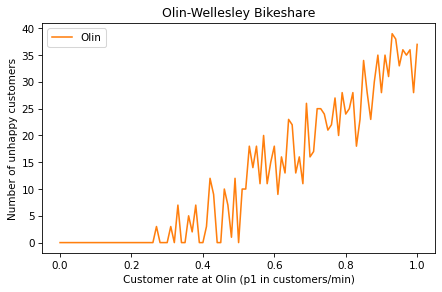

In [25]:
p1_array = linspace(0, 1, 101)
sweep2 = sweep_p1(p1_array)
sweep2.plot(label='Olin', color='C1')
decorate(title='Olin-Wellesley Bikeshare',
         xlabel='Customer rate at Olin (p1 in customers/min)', 
         ylabel='Number of unhappy customers')

### Exercise 4

 Write a function called `sweep_p2` that runs simulations with `p1=0.5` and a range of values for `p2`.  It should store the results in a `SweepSeries` and return the `SweepSeries`.


In [26]:
def sweep_p2(p2_array):
    p1 = 0.5
    num_steps = 60
    sweep = SweepSeries()
    
    for p2 in p2_array:
        state = run_simulation(p1, p2, num_steps)
        sweep[p2] = state.olin_empty
        
    return sweep

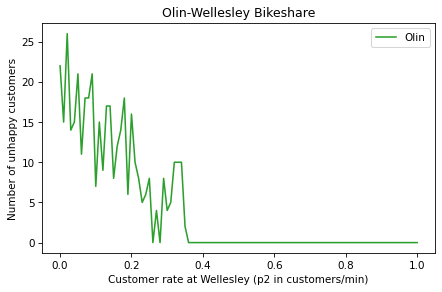

In [27]:
p2_array = linspace(0, 1, 101)
sweep3 = sweep_p2(p2_array)
sweep3.plot(label='Olin', color='C2')

decorate(title='Olin-Wellesley Bikeshare',
         xlabel='Customer rate at Wellesley (p2 in customers/min)', 
         ylabel='Number of unhappy customers')

## Challenge Exercises

The following two exercises are a little more challenging.  If you are comfortable with what you have learned so far, you should give them a try.  If you feel like you have your hands full, you might want to skip them for now.

### Exercise 5

 Because our simulations are random, the results vary from one run to another, and the results of a parameter sweep tend to be noisy.  We can get a clearer picture of the relationship between a parameter and a metric by running multiple simulations with the same parameter and taking the average of the results.

Write a function called `run_multiple_simulations` that takes as parameters `p1`, `p2`, `num_steps`, and `num_runs`.
`num_runs` specifies how many times it should call `run_simulation`.

After each run, it should store the total number of unhappy customers (at Olin or Wellesley) in a `TimeSeries`.
At the end, it should return the `TimeSeries`.

Test your function with parameters

```
p1 = 0.3
p2 = 0.3
num_steps = 60
num_runs = 10
```

Display the resulting `TimeSeries` and use the `mean` function from NumPy to compute the average number of unhappy customers.

In [28]:
def run_multiple_simulations(p1, p2, num_steps, num_runs):
    totals = TimeSeries()
    
    for i in range(num_runs):
        state = run_simulation(p1, p2, num_steps)
        totals[i] = state.olin_empty + state.wellesley_empty
        
    return totals

In [29]:
p1 = 0.3
p2 = 0.3
num_steps = 60
num_runs = 10
totals = run_multiple_simulations(p1, p2, num_steps, num_runs)
show(totals)

,Quantity
Time,
0,4
1,3
2,7
3,6
4,1
5,1
6,6
7,0
8,2


In [30]:
from numpy import mean

mean(totals)

3.1

### Exercise 6

Continuing the previous exercise, use `run_multiple_simulations` to run simulations with a range of values for `p1` and `p2`.

```
p2 = 0.3
num_steps = 60
num_runs = 20
```

Store the results in a `SweepSeries`, then plot the average number of unhappy customers as a function of `p1`.  Label the axes.

What value of `p1` minimizes the average number of unhappy customers?

In [31]:
p2 = 0.3
num_steps = 60
num_runs = 20

In [32]:
p1_array = linspace(0, 1, 20)
p2 = 0.3
num_steps = 60
num_runs = 20

sweep4 = SweepSeries()
for p1 in p1_array:
    totals = run_multiple_simulations(p1, p2, num_steps, num_runs)
    sweep4[p1] = mean(totals)

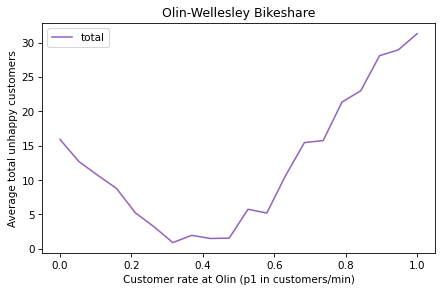

In [33]:
sweep4.plot(label='total', color='C4')
    
decorate(title='Olin-Wellesley Bikeshare',
         xlabel='Customer rate at Olin (p1 in customers/min)', 
         ylabel='Average total unhappy customers')

## Under the Hood

The object you get when you call `SweepSeries` is actually a Pandas `Series`, the same as the object you get from `TimeSeries`.
I give them different names to help us remember that they play different roles.

`Series` provides a number of functions, which you can read about at <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html>.

They include `mean`, which computes the average of the values in the `Series`, so if you have a `Series` named `totals`, for example, you can compute the mean like this:

```
    totals.mean()
```

`Series` provides other statistical functions, like `std`, which computes the standard deviation of the values in the series.

In this chapter I use the keyword argument `color` to specify the color of a line plot.
You can read about the other available colors at <https://matplotlib.org/3.3.2/tutorials/colors/colors.html>.